## Understanding the Training Phase

#### Importing Necessary Libraries

In [1]:
import sys
sys.path.append('../')

import os
import pickle
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
from utils.metrics import plot_metrics, plot_confusion_matrix, plot_selected_images, plot_train_loss, plot_valid_loss, plot_valid_accuracies

#### Preparing Training Data

In [2]:
# Directory where the .pkl files are stored
logs_dir = '../logs/'

# List of models
models = ["simple-cnn", "mobile-net", "shuffle-net", "resnet18", "resnet34"]

# Dictionary to store the training metrics for each model
training_metrics = {}

# Loop through each model
for model in models:
    # File name of the .pkl file
    file_name = f"{model}_07_04_2024.pkl"
    file_path = os.path.join(logs_dir, file_name)
    
    # Check if the file exists
    if os.path.exists(file_path):
        # Load the .pkl file
        with open(file_path, 'rb') as f:
            metrics = pickle.load(f)
        
        # Store the metrics in the dictionary
        training_metrics[model] = metrics
    else:
        print(f"Warning: File {file_name} not found.")


#### Plotting Training Data

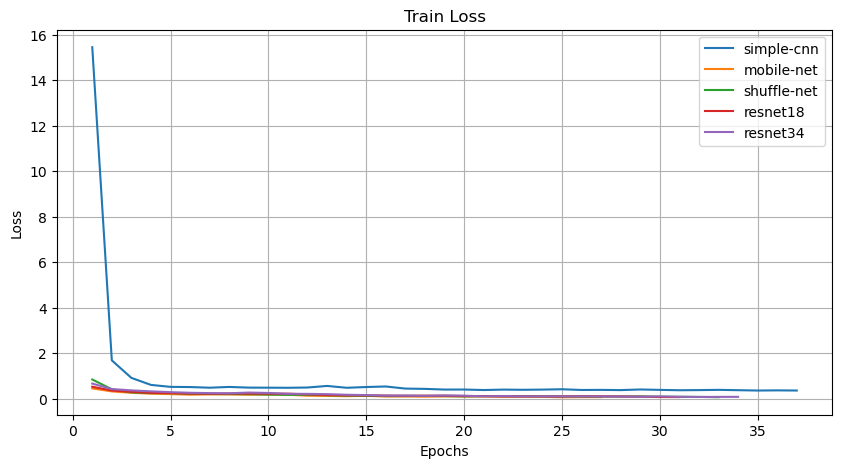

In [3]:
plot_train_loss(training_metrics)

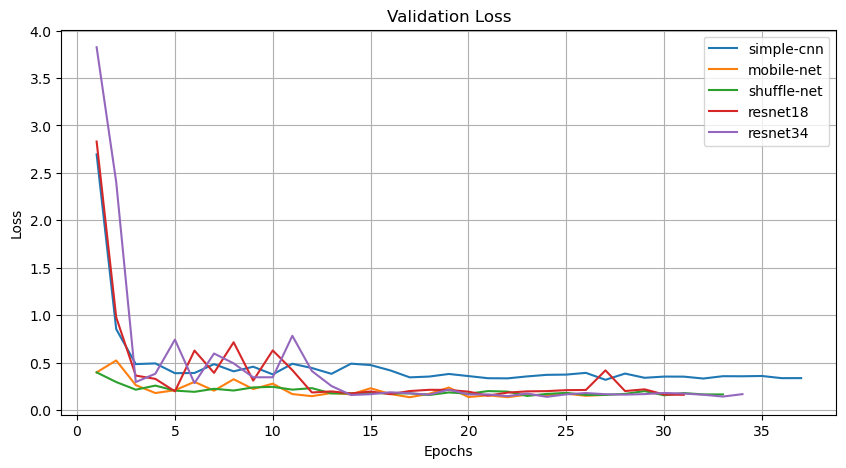

In [4]:
plot_valid_loss(training_metrics)

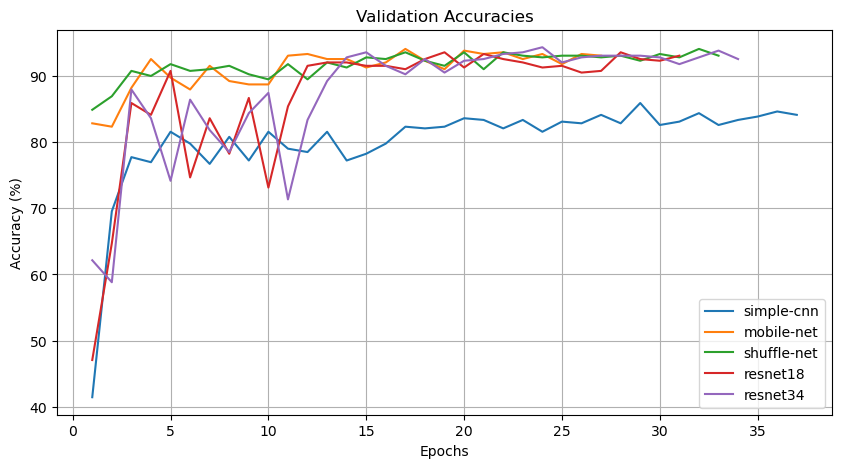

In [5]:
plot_valid_accuracies(training_metrics)

### Training Data Analysis

**Training Loss Reduction:** All models show a significant reduction in training loss over epochs, indicating effective learning during training.

**Validation Loss and Accuracy:** The validation loss and accuracy metrics provide insights into how well the models generalize to unseen data. Lower validation losses and higher validation accuracies generally indicate better performance. It's noticeable that as the training progresses, most models achieve lower validation losses and higher accuracies.

**Learning Rates:** The learning rates decrease over epochs, as expected with our learning rate scheduling technique to stabilize training and improve convergence.

**Model Performance:** Each model exhibits varying levels of performance. For instance, MobileNet tends to converge faster and achieves higher validation accuracy compared to other models like Simple CNN and ResNet18.

**Model Complexity:** More complex models like ResNet34 have higher parameter counts and tend to take longer to train but can potentially achieve better performance given enough data and training time.

*Overall, these insights help in understanding how different architectures and hyperparameters affect the training dynamics and performance of the models. Adjustments in architecture or hyperparameters can be made based on these insights to further optimize model performance.*

## Understanding the Results

#### Define a Function to Load Results

In [6]:
def load_results(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

#### Loading and Preparing Data for Plotting

In [7]:
model_names = ["simple-cnn", "mobile-net", "shuffle-net", "resnet18", "resnet34"]
all_results = {}

for model in model_names:
    results_path = f'../logs/test_results_{model}.pkl'
    with open(results_path, 'rb') as file:
        all_results[model] = pickle.load(file)

In [8]:
accuracy_df = pd.DataFrame()
precision_df = pd.DataFrame()
recall_df = pd.DataFrame()
f1_score_df = pd.DataFrame()

for model, data in all_results.items():
    accuracy_df[model] = [data['accuracy']]
    precision_df[model] = [data['precision']]
    recall_df[model] = [data['recall']]
    f1_score_df[model] = [data['f1_score']]

#### Plotting Metrics (Accuracy, Precision, Recall, F1-Score)

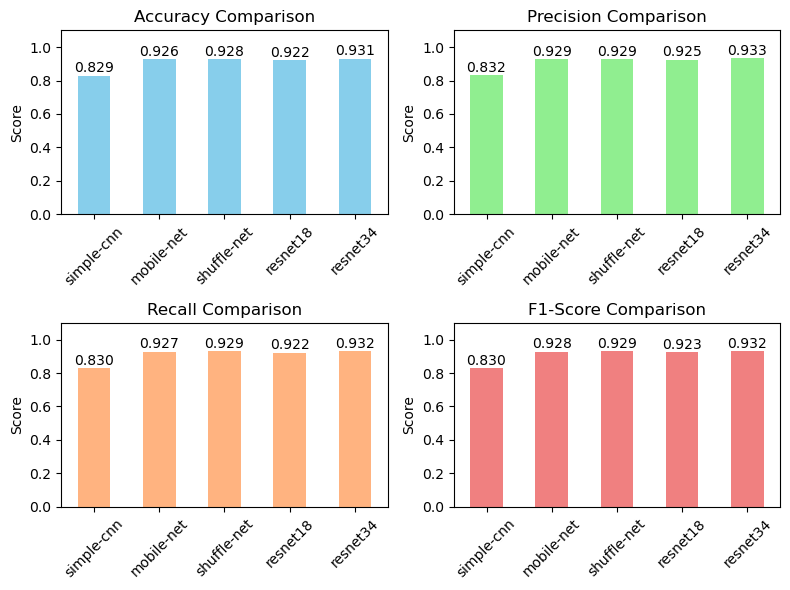

In [9]:
plot_metrics(accuracy_df, precision_df, recall_df, f1_score_df)

#### Performance Analysis of Different Models

The results present a comparison of five different models: **simple-cnn**, **mobile-net**, **shuffle-net**, **resnet18**, and **resnet34** across four key metrics - accuracy, precision, recall, and F1-score.

**Accuracy:** The results show that all models performed well, with mobile-net, shuffle-net, and resnet34 leading the group, all achieving over 92% accuracy. This suggests a high level of overall correctness in their predictions.

**Precision:** Precision follows a similar trend as accuracy, with the more complex models (mobile-net, shuffle-net, and resnet34) displaying marginally higher precision. This indicates a strong ability to **minimize false positives**.

**Recall:** In terms of recall, all models demonstrate a good ability to correctly identify all relevant instances. Resnet34 slightly outperforms the others, indicating its effectiveness in minimizing false negatives.

**F1-Score:** The F1-score, which balances precision and recall, also reflects high performance across the board, with resnet34 slightly leading. This suggests a balanced trade-off between precision and recall in this model.

In summary, while the simple-cnn model shows commendable performance, more complex models like resnet34 and shuffle-net exhibit marginally better overall metrics, likely benefiting from their deeper and more intricate architectures. This comparison is crucial in guiding the choice of model for specific tasks, balancing computational efficiency and model accuracy.

#### Plotting the Confusion Matrix

The confusion matrix for the ResNet34 model provides insights into its performance across the three classes: "Normal," "Lung Opacity," and "Viral Pneumonia."

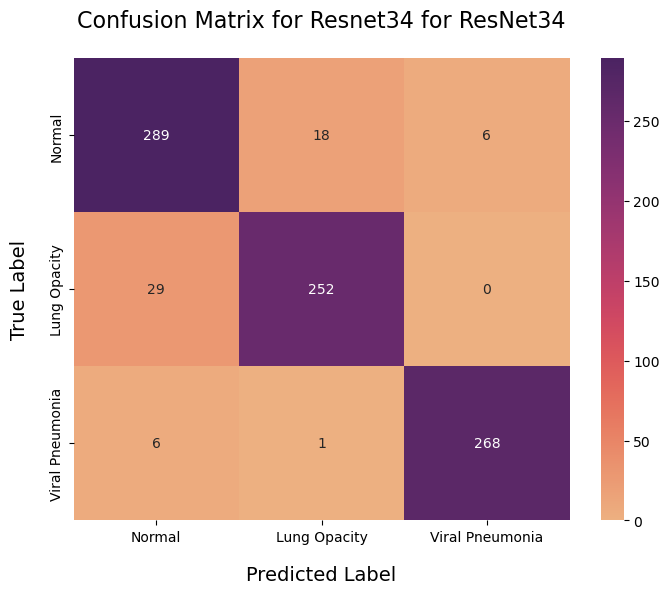

In [10]:
conf_matrix_resnet34 = all_results['resnet34']['confusion_matrix']
plot_confusion_matrix(conf_matrix_resnet34, title='Confusion Matrix for Resnet34')

- For "Normal" cases (first row), out of 313 actual instances (289+18+6), the model correctly predicted **289** as "Normal." However, it misclassified **18** as "Lung Opacity" and **6** as "Viral Pneumonia."

- In diagnosing "Lung Opacity" (second row), of **281** actual cases (29+252+0), **252** were accurately identified, whereas **29** were incorrectly labeled as "Normal."

- Regarding "Viral Pneumonia" (third row), the model performed impressively, correctly identifying **268** out of **275** cases (6+1+268), with only **6** misclassified as "Normal" and **1** as "Lung Opacity."

**Key Observations:**
- The model is highly effective in distinguishing "Viral Pneumonia" cases, as indicated by the high number of true positives (268) compared to the few false negatives (7).

- There is some confusion between "Normal" and "Lung Opacity," which might be due to similarities in their radiographic appearances.

- The overall diagonal values (289, 252, 268), which represent correct predictions, are significantly higher than the off-diagonal values, indicating strong model performance across all classes.

**True Positives vs. False Positives in Medical Diagnostics:**

**True Positives**: Correctly identifying a disease is vital. It leads to timely and proper treatment, which can be critical for patient survival and helps in effective treatment planning.

**False Positives**: Misdiagnosing a disease in a healthy person can have detrimental consequences. It can cause undue stress and anxiety, lead to unnecessary treatments with potential side effects, and result in economic costs due to unneeded medical procedures.

**Conclusion:**
The ResNet34 model demonstrates robust diagnostic capabilities with high accuracy, particularly in identifying "Viral Pneumonia." The minor confusions between "Normal" and "Lung Opacity" cases suggest a need for further fine-tuning or more discriminative features to enhance separation between these classes.

#### Investigating Errors and Outliers

In [14]:
# Loading tests results for resnet34
test_results = all_results['resnet34']

# Extracting info
image_paths = test_results['image_paths']
predicted_labels = test_results['predictions']
true_labels = test_results['labels']

# Labels
label_mapping = {0: "Normal", 1: "Lung Opacity", 2: "Viral Pneumonia"}

# finding missclassifcations
incorrect_preds = [i for i, (pred, true) in enumerate(zip(predicted_labels, true_labels)) if pred != true]

# finding correct classifications
correct_preds = [i for i, (pred, true) in enumerate(zip(predicted_labels, true_labels)) if pred == true]

# Picking missclassifications examples randomly
selected_correct_indices = random.sample(correct_preds, k=4)

# Picking missclassifications examples randomly
selected_misclassification_indices = random.sample(incorrect_preds, k=4)

Correct Classifications

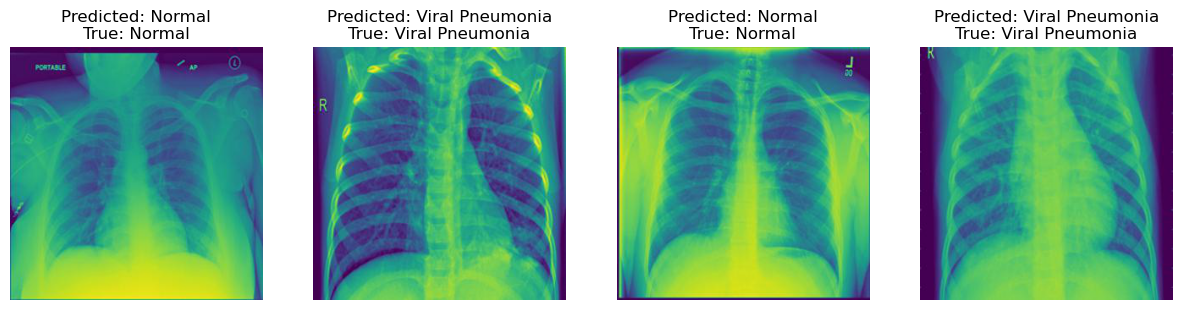

In [15]:
plot_selected_images(image_paths, predicted_labels, true_labels, label_mapping, selected_correct_indices)

Misclassifications

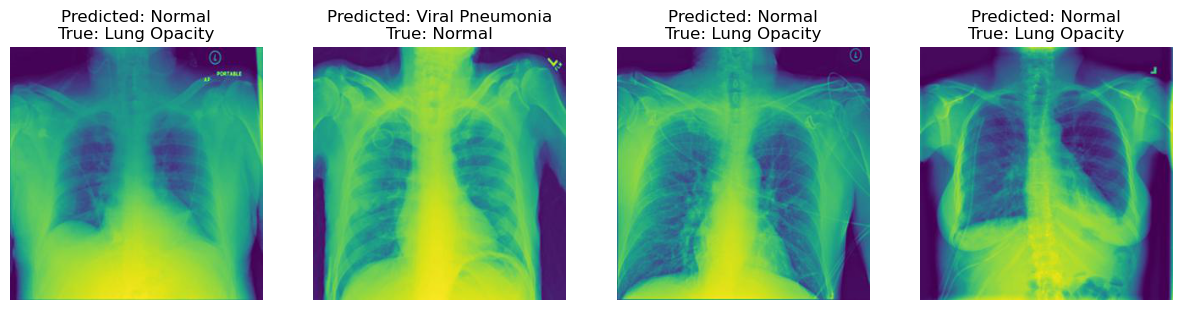

In [16]:
plot_selected_images(image_paths, predicted_labels, true_labels, label_mapping, selected_misclassification_indices)

As someone with a background outside of medicine, comprehending the intricacies of classification errors in medical image analysis can be daunting. When a model misclassifies an image, it raises questions about the underlying factors contributing to the misinterpretation. In medical image analysis, errors often stem from the complex nature of diseases, variations in imaging techniques, and the inherent challenges of machine learning models. False positives, where the model incorrectly identifies a disease, and false negatives, where it fails to detect a disease, are common types of errors. False positives may trigger unnecessary interventions and patient anxiety, while false negatives could lead to missed diagnoses and delayed treatments, emphasizing the critical importance of accurate image classification in medical settings.

**Furthermore, it's important to note that this exercise is biased towards machine learning and analysis, rather than diagnostic purposes. While our focus is on enhancing image classification accuracy through computational methods, it's crucial to recognize that the findings of this study are primarily intended to contribute to the advancement of machine learning techniques in medical image analysis, rather than serving as a diagnostic tool.**